Problem definition

In [1]:
import numpy as np
from scipy.optimize import minimize
from desdeo_problem import variable_builder, ScalarObjective, MOProblem
from desdeo_problem.testproblems.TestProblems import test_problem_builder
import plotly.graph_objects as go
from desdeo_mcdm.utilities.solvers import solve_pareto_front_representation
from desdeo_mcdm.interactive.ReferencePointMethod import ReferencePointMethod
import matplotlib.pyplot as plt

from gekko import GEKKO

# Initialize Model
m = GEKKO(remote=False)
m.options.DIAGLEVEL=5

In [2]:
# Define objective functions
def f1(x):
    return x**2

def f2(x):
    return (x-2)**2
    
# Constraint functions with additional parameters
def constraint1(alpha, w, z_i, z_dot):
    return (w[0] * (z_i[0] - (z_dot[0]))) - alpha

def constraint2(alpha, w, z_i, z_dot):
    return (w[1] * (z_i[1] - (z_dot[1]))) - alpha


def compute_multipliers_gekko(fx, z_i, w):
    # Initialize Model
    m = GEKKO(remote=False)
    m.options.DIAGLEVEL=2
    
    # Define Variables
    alpha = m.Var(value=0)  # Variable alpha
    
    # Define a list of weights (w) and average values (z̄)
    #w = [0.3, 0.3, 0.4]  # Example weights
    #z_bar = [0.1, 0.1, 0.1]  # Example average value
    
    #z_i = [0.28, 0.53, 0.53]
    #z_dot = [0,0,0]
    #d = [0,0,0]
    
    # Define Objective Function
    m.Obj(alpha)  # Objective function to minimize
    
    # Define Constraints
    m.Equation(w[0] * (fx[0] - z_i[0] ) <= alpha)
    m.Equation(w[1] * (fx[1] - z_i[1]) <= alpha)
    #m.Equation(w[2] * (z_i[2] - (z_dot[2] + d[2])) <= alpha)
    
    # Solve the Optimization Problem
    m.solve(disp=True)
    
    # Print Results
    print(f"Optimal value of alpha: {alpha.value[0]}")
    
    print('Lagrange multipliers')
    lam = np.loadtxt(m.path + '/apm_lam.txt')
    print(lam)
    return lam

def compute_multipliers(w, z_i, z_dot):
    # Initial guess for alpha
    initial_guess = [0]
    
    # Define the bounds for alpha
    bounds = ((0, None),)  # No bounds for alpha
    
    # Define the constraints
    constraints = [{'type': 'ineq', 'fun': lambda x: constraint1(x, w, z_i, z_dot)},
                   {'type': 'ineq', 'fun': lambda x: constraint2(x, w, z_i, z_dot)}]

    
    # Minimize alpha subject to the constraints
    result = minimize(lambda x: -x[0], initial_guess, bounds=bounds, constraints=constraints, method='trust-constr')
    
    print("Optimal Solution for alpha:", result.x)
    
    # Calculate Lagrange multipliers
    lagrange_multipliers = np.array([item for sublist in result.v for item in sublist])
    lagrange_multipliers[0:3] *= -1
    print("Lagrange Multipliers:", lagrange_multipliers)
    return lagrange_multipliers[0:3]


In [3]:
def compute_approximate_pareto_optimal_objective_vector(dot_z, lambdas, d, weights):
    """
    Compute the approximate Pareto optimal objective vector.

    Args:
    dot_z (numpy.ndarray): Current objective vector.
    d (numpy.ndarray): Direction vector.
    n (numpy.ndarray): Normal vector.
    w_inv (numpy.ndarray): Inverse of the weight vector.

    Returns:
    numpy.ndarray: Approximate Pareto optimal objective vector.
    """
    k = len(dot_z)  # Number of objectives
    w_inv = 1 / np.array(weights)
    n = -np.array([lambdas[i] * weights[i] for i in range(k)])
    dot_z = np.array(dot_z)
    d = np.array(d)
    n = np.array(n)
    w_inv = np.array(w_inv)
    t = -np.dot(n.T, d) / np.dot(n.T, w_inv)
    approximate_z = dot_z + d + t * w_inv
    return approximate_z

C:\Users\Giomara\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimal Solution for alpha: [0.24967063]
Lagrange Multipliers: [0.50032041 0.50032041 0.00064082]


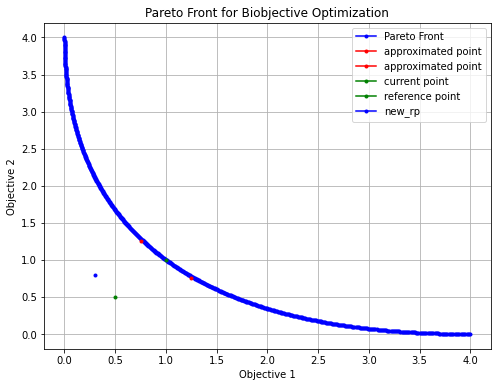

In [4]:
# Main function to compute and plot Pareto front
def plot(w, z_i, z_dot, d, approximate_z, approximate_z2):
    # Decision variable range
    x = np.linspace(0, 3, 1000)
    
    # Compute objective values
    y1 = f1(x)
    y2 = f2(x)
    
    # Find non-dominated solutions
    pareto_front = []
    for i in range(len(x)):
        dominated = False
        for j in range(len(x)):
            if i != j:
                if y1[j] <= y1[i] and y2[j] <= y2[i]:
                    dominated = True
                    break
        if not dominated:
            pareto_front.append((y1[i], y2[i]))
    
    pareto_front = np.array(pareto_front)
    
    # Plot Pareto front
    plt.figure(figsize=(8, 6))
    plt.plot(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', color='blue', marker='.')
    plt.plot(approximate_z[0], approximate_z[1], label='approximated point', color='red', marker='.')
    plt.plot(approximate_z2[0], approximate_z2[1], label='approximated point', color='red', marker='.')
    plt.plot(z_i[0], z_i[1], label='current point', color='green', marker='.')
    plt.plot(z_dot[0], z_dot[1], label='reference point', color='green', marker='.')
    plt.plot(z_dot[0] + d[0], z_dot[1] + d[1], label='new_rp', color='blue', marker='.')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.title('Pareto Front for Biobjective Optimization')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
   
    w = [0.5,0.5]
    z_i = [1,1]
    w_inv = 1 / np.array(w)
   
    z_dot = [0.5,0.5]
    new_rp = [1, 0.7]
    d = [-0.2, 0.3]
    d2 = [0.2,-0.3]
   
    # Compute normal vector n
    #lagrange_multipliers = compute_multipliers_gekko(z_i, z_dot, w)
    lagrange_multipliers = compute_multipliers(w, z_i, z_dot)
    approximate_z = compute_approximate_pareto_optimal_objective_vector(z_i,lagrange_multipliers, d, w)
    approximate_z2 = compute_approximate_pareto_optimal_objective_vector(z_i,lagrange_multipliers, d2, w)
    #lagrange_scipy = compute_multipliers(w, z_i, z_dot)
    #print(lagrange_scipy)
    plot(w, z_i, z_dot, d, approximate_z, approximate_z2)
    #print(approximate_z)
